## Synthetic spectra generator

In [1]:
#First reset sys path so we use the correct envoirnment
import sys
sys.path=['', 'C:\\Users\\bryan\\Anaconda3\\envs\\tensorflow_GPU\\python37.zip', 'C:\\Users\\bryan\\Anaconda3\\envs\\tensorflow_GPU\\DLLs', 'C:\\Users\\bryan\\Anaconda3\\envs\\tensorflow_GPU\\lib', 'C:\\Users\\bryan\\Anaconda3\\envs\\tensorflow_GPU', 'C:\\Users\\bryan\\AppData\\Roaming\\Python\\Python37\\site-packages', 'C:\\Users\\bryan\\Anaconda3\\envs\\tensorflow_GPU\\lib\\site-packages']

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
n_points = 640

In [2]:
import tensorflow as tf
import keras.backend as K
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv1D, Flatten, BatchNormalization, Activation, Dropout
from keras import regularizers
from datetime import datetime

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
tf.keras.backend.clear_session()
model = Sequential()

model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None,input_shape = (n_points, 1)))

model.add(Activation('relu'))

model.add(Conv1D(128, activation = 'relu', kernel_size = (32)))
model.add(Conv1D(64, activation = 'relu', kernel_size = (16)))
model.add(Conv1D(16, activation = 'relu', kernel_size = (8)))
model.add(Conv1D(16, activation = 'relu', kernel_size = (8)))
model.add(Conv1D(16, activation = 'relu', kernel_size = (8)))
model.add(Dense(32, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1 = 0, l2=0.1)))
model.add(Dense(16, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1 = 0, l2=0.1)))
model.add(Flatten())
model.add(Dropout(.25))
model.add(Dense(n_points, activation='relu'))


model.compile(loss='mse', optimizer='Adam', metrics=['mean_absolute_error','mse','accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 640, 1)            4         
_________________________________________________________________
activation (Activation)      (None, 640, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 609, 128)          4224      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 594, 64)           131136    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 587, 16)           8208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 580, 16)           2064      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 573, 16)           2

## Training

In [5]:
from Generate_Data import *
for dataset_num in range(1,10):
    #X, y = generate_datasets_for_Paper_1(dataset_num,50000)
    temp, y = generate_datasets_(dataset_num,50000)
    X = np.empty((50000,640,1))
    X[:,:,0]=temp
    
    if dataset_num == 1:
        a=1
        b='a'
    elif dataset_num == 2:
        a=1
        b='b'
    elif dataset_num == 3:
        a=1
        b='c'
    elif dataset_num == 4:
        a=2
        b='a'
    elif dataset_num == 5:
        a=2
        b='b'
    elif dataset_num == 6:
        a=2
        b='c'
    elif dataset_num == 7:
        a=3
        b='a'
    elif dataset_num == 8:
        a=3
        b='b'
    else:
        a=3
        b='c'
    

    history = model.fit(X, y,epochs=10, verbose = 1, validation_split=0.25, batch_size=256) 
    my_path='./data/'+str(a)+b+'PAPER1'
    model.save(my_path)
    hist_df = pd.DataFrame(history.history) 
    with open(my_path+'.csv', mode='w') as f:
        hist_df.to_csv(f)
    
    
    my_path='./data/'+str(a)+b+'PAPER1'
    #history = load_model(my_path)
    # plt.plot(history.history['loss']) 
    # plt.plot(history.history['val_loss'])
    # plt.title('Model loss')
    # plt.ylabel('Loss')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Test'], loc='upper left')
    # plt.show()


    size1=100
    name1='./data/' +str(a)+b+'Raman_spectrums_valid.csv'
    name2= './data/'+str(a)+b+'CARS_spectrums_valid.csv'
    RAMAN = pd.read_csv(name1)
    BCARS = pd.read_csv(name2)
    RAMAN = RAMAN.values[:,1:]
    BCARS = BCARS.values[:,1:]
    
    #interpolate 1000 samples down to 640 samples
    from scipy import interpolate 
    min_wavenumber = 0.1
    max_wavenumber = 2000
    n_points = 1000
    step = (max_wavenumber-min_wavenumber)/(n_points)
    wavenumber_axis = np.arange(min_wavenumber, max_wavenumber, step)
    f_RAMAN = interpolate.interp1d(wavenumber_axis, RAMAN, kind='cubic')
    f_BCARS = interpolate.interp1d(wavenumber_axis, BCARS, kind='cubic')

    n_points = 640
    step = (max_wavenumber-min_wavenumber)/(n_points)
    new_axis = np.arange(min_wavenumber, max_wavenumber, step)
    RAMAN = f_RAMAN(new_axis)
    BCARS = f_BCARS(new_axis)
    #end interpolation
    
    
    RESULTS = RAMAN[:,:]
    print(np.shape(BCARS))
    X = np.empty((1, n_points,1))

    for m in range(size1):
        X[0,:,0]=BCARS[m,:]
        yhat = model.predict(X, verbose =0)
        RESULTS[m,:]=yhat.flatten()
        #print(RESULTS[m,:])

    #    print(np.shape(yhat))
    #     f, a = plt.subplots(2,1, sharex=True)
    #     a[0].plot(X.flatten(), label = 'cars')
    #     a[1].plot(RAMAN[m,:].T+.7, label = 'true',c= 'g' )
    #     a[1].plot(yhat.flatten()+1.4, label = 'pred.',c='r')
    #     plt.subplots_adjust(hspace=0)

    pd.DataFrame(RESULTS).to_csv('./data/' +str(a)+b+'Raman_spectrums_valid_PAPER1.csv')


Epoch 1/10
147/147 [==============================] - 6s 39ms/step - loss: 2.1497 - mean_absolute_error: 0.0175 - mse: 0.0023 - accuracy: 0.2147 - val_loss: 0.9652 - val_mean_absolute_error: 0.0130 - val_mse: 0.0017 - val_accuracy: 0.3613
Epoch 2/10
147/147 [==============================] - 5s 37ms/step - loss: 0.4949 - mean_absolute_error: 0.0112 - mse: 9.7901e-04 - accuracy: 0.5041 - val_loss: 0.1960 - val_mean_absolute_error: 0.0101 - val_mse: 9.1942e-04 - val_accuracy: 0.5448
Epoch 3/10
147/147 [==============================] - 5s 37ms/step - loss: 0.0919 - mean_absolute_error: 0.0084 - mse: 5.4674e-04 - accuracy: 0.6209 - val_loss: 0.0309 - val_mean_absolute_error: 0.0079 - val_mse: 5.4450e-04 - val_accuracy: 0.6081
Epoch 4/10
147/147 [==============================] - 5s 37ms/step - loss: 0.0133 - mean_absolute_error: 0.0069 - mse: 3.4110e-04 - accuracy: 0.6654 - val_loss: 0.0039 - val_mean_absolute_error: 0.0061 - val_mse: 3.0499e-04 - val_accuracy: 0.7284
Epoch 5/10
147/147 [

147/147 [==============================] - 6s 38ms/step - loss: 5.3358e-04 - mean_absolute_error: 0.0117 - mse: 4.7699e-04 - accuracy: 0.6051 - val_loss: 3.7652e-04 - val_mean_absolute_error: 0.0098 - val_mse: 3.2897e-04 - val_accuracy: 0.7186
Epoch 7/10
147/147 [==============================] - 6s 39ms/step - loss: 5.0761e-04 - mean_absolute_error: 0.0115 - mse: 4.6120e-04 - accuracy: 0.6137 - val_loss: 6.8498e-04 - val_mean_absolute_error: 0.0131 - val_mse: 6.3631e-04 - val_accuracy: 0.7166
Epoch 8/10
147/147 [==============================] - 6s 39ms/step - loss: 5.0542e-04 - mean_absolute_error: 0.0114 - mse: 4.5353e-04 - accuracy: 0.6200 - val_loss: 3.3974e-04 - val_mean_absolute_error: 0.0093 - val_mse: 2.9549e-04 - val_accuracy: 0.7366
Epoch 9/10
147/147 [==============================] - 6s 39ms/step - loss: 5.2122e-04 - mean_absolute_error: 0.0116 - mse: 4.6777e-04 - accuracy: 0.6175 - val_loss: 4.2027e-04 - val_mean_absolute_error: 0.0096 - val_mse: 3.0578e-04 - val_accuracy

Epoch 4/10
147/147 [==============================] - 5s 35ms/step - loss: 5.4336e-04 - mean_absolute_error: 0.0137 - mse: 5.0734e-04 - accuracy: 0.7049 - val_loss: 4.1086e-04 - val_mean_absolute_error: 0.0121 - val_mse: 3.7358e-04 - val_accuracy: 0.8136
Epoch 5/10
147/147 [==============================] - 5s 35ms/step - loss: 5.6827e-04 - mean_absolute_error: 0.0141 - mse: 5.3074e-04 - accuracy: 0.7057 - val_loss: 4.1561e-04 - val_mean_absolute_error: 0.0123 - val_mse: 3.7761e-04 - val_accuracy: 0.8183
Epoch 6/10
147/147 [==============================] - 5s 35ms/step - loss: 5.4618e-04 - mean_absolute_error: 0.0138 - mse: 5.0852e-04 - accuracy: 0.7105 - val_loss: 4.4233e-04 - val_mean_absolute_error: 0.0124 - val_mse: 4.0578e-04 - val_accuracy: 0.8285
Epoch 7/10
147/147 [==============================] - 5s 35ms/step - loss: 5.2580e-04 - mean_absolute_error: 0.0135 - mse: 4.8951e-04 - accuracy: 0.7094 - val_loss: 4.0259e-04 - val_mean_absolute_error: 0.0119 - val_mse: 3.6688e-04 - v

Epoch 2/10
147/147 [==============================] - 5s 35ms/step - loss: 0.0011 - mean_absolute_error: 0.0222 - mse: 0.0010 - accuracy: 0.7067 - val_loss: 0.0010 - val_mean_absolute_error: 0.0222 - val_mse: 9.7288e-04 - val_accuracy: 0.8000
Epoch 3/10
147/147 [==============================] - 5s 35ms/step - loss: 0.0011 - mean_absolute_error: 0.0219 - mse: 0.0010 - accuracy: 0.7123 - val_loss: 0.0010 - val_mean_absolute_error: 0.0214 - val_mse: 9.9905e-04 - val_accuracy: 0.8030
Epoch 4/10
147/147 [==============================] - 5s 35ms/step - loss: 0.0010 - mean_absolute_error: 0.0215 - mse: 9.6450e-04 - accuracy: 0.7112 - val_loss: 0.0010 - val_mean_absolute_error: 0.0212 - val_mse: 9.6923e-04 - val_accuracy: 0.7791
Epoch 5/10
147/147 [==============================] - 5s 35ms/step - loss: 0.0010 - mean_absolute_error: 0.0217 - mse: 9.7861e-04 - accuracy: 0.7133 - val_loss: 0.0011 - val_mean_absolute_error: 0.0217 - val_mse: 0.0011 - val_accuracy: 0.8127
Epoch 6/10
147/147 [====

Use this function to test the model on single instances

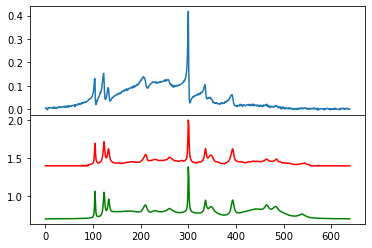

In [10]:
def predict_and_plot():

    
    temp, y = generate_datasets_(dataset_num,1)
    X = np.empty((1,640,1))
    X[:,:,0]=temp
    yhat = model.predict(X, verbose =0)
    f, a = plt.subplots(2,1, sharex=True)
    a[0].plot(X.flatten(), label = 'cars')
    a[1].plot(y.T+.7, label = 'true',c= 'g' )
    a[1].plot(yhat.flatten()+1.4, label = 'pred.',c='r')
    plt.subplots_adjust(hspace=0)
    #return x, y.flatten(), yhat.flatten(), chi3, NRB
predict_and_plot()

In [9]:
# #predict_and_plot()
# for dataset_num in range(1,2):
#     if dataset_num == 1:
#         a=1
#         b='a'
#     elif dataset_num == 2:
#         a=1
#         b='b'
#     elif dataset_num == 3:
#         a=1
#         b='c'
#     elif dataset_num == 4:
#         a=2
#         b='a'
#     elif dataset_num == 5:
#         a=2
#         b='b'
#     elif dataset_num == 6:
#         a=2
#         b='c'
#     elif dataset_num == 7:
#         a=3
#         b='a'
#     elif dataset_num == 8:
#         a=3
#         b='b'
#     else:
#         a=3
#         b='c'
#     my_path='./data/'+str(a)+b+'PAPER1'
#     history = load_model(my_path)
#     # plt.plot(history.history['loss']) 
#     # plt.plot(history.history['val_loss'])
#     # plt.title('Model loss')
#     # plt.ylabel('Loss')
#     # plt.xlabel('Epoch')
#     # plt.legend(['Train', 'Test'], loc='upper left')
#     # plt.show()


#     size1=10
#     name1='./data/' +str(a)+b+'Raman_spectrums_valid.csv'
#     name2= './data/'+str(a)+b+'CARS_spectrums_valid.csv'
#     RAMAN = pd.read_csv(name1)
#     BCARS = pd.read_csv(name2)
#     RAMAN = RAMAN.values[:,1:]
#     BCARS = BCARS.values[:,1:]
    
    
#     from scipy import interpolate 
#     min_wavenumber = 0.1
#     max_wavenumber = 2000
#     n_points = 1000
#     step = (max_wavenumber-min_wavenumber)/(n_points)
#     wavenumber_axis = np.arange(min_wavenumber, max_wavenumber, step)
#     f_RAMAN = interpolate.interp1d(wavenumber_axis, RAMAN, kind='cubic')
#     f_BCARS = interpolate.interp1d(wavenumber_axis, BCARS, kind='cubic')

#     n_points = 640
#     step = (max_wavenumber-min_wavenumber)/(n_points)
#     new_axis = np.arange(min_wavenumber, max_wavenumber, step)
#     RAMAN = f_RAMAN(new_axis)
#     BCARS = f_BCARS(new_axis)
#     #end interpolation
    
    
    
#     RESULTS = RAMAN[:,:]
#     #print(np.shape(BCARS))
#     X = np.empty((1, n_points,1))

#     for m in range(size1):
#         X[0,:,0]=BCARS[m,:]
#         yhat = model.predict(X, verbose =0)
#         RESULTS[m,:]=yhat.flatten()
#         #print(RESULTS[m,:])

#     #    print(np.shape(yhat))
#         f, a = plt.subplots(2,1, sharex=True)
#         a[0].plot(X.flatten(), label = 'cars')
#         a[1].plot(RAMAN[m,:].T+.7, label = 'true',c= 'g' )
#         a[1].plot(yhat.flatten()+1.4, label = 'pred.',c='r')
#         plt.subplots_adjust(hspace=0)

#     #pd.DataFrame(RESULTS).to_csv('./data/' +str(a)+b+'Raman_spectrums_valid_PAPER1.csv')